# In case of using colab
Remember to connect to your drive and upload the dataset if you want to repeat several times  this tutorial

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
%cd /content/drive/MyDrive/2025 Primavera/hands-on
!ls

/content/drive/MyDrive/2025 Primavera/hands-on
botsort.yaml	       images			       videos
bytetrack.yaml	       __pycache__		       weights
cherry.yaml	       runs			       yolo11n.pt
datasets	       short_video2.mov		       yolov11_best2.pt
Experimentos.gsheet    tracking_utils.py	       yolov11_best.pt
Fruit-detection.ipynb  train.zip		       yolov11.yaml
FruitTracking2.ipynb   val-20251210T174020Z-3-001.zip
FruitTracking.ipynb    val.zip


# Download the dataset

In this occasion we are going to use different video footage of cherry trees to test a tracking algorithm.


[videos-cherry](https://drive.google.com/drive/folders/1H0jr8uhQLkxs_wNjQqUiews_CLIFUdMV?usp=sharing)


# Install repositories
The repository for this hands on is:

```code
git clone https://github.com/LuisCossioUOH/Hands-On-Lacoro2025-Fruit-Tracking
```

You can either clone the reposritory or upload the tracking_utils.py file:

And install ultralytics
```code
pip install ultralytics==8.3.94
```

In [3]:
# !git clone https://github.com/LuisCossioUOH/Hands-On-Lacoro2025-Fruit-Tracking
# !mv Hands-On-Lacoro2025-Fruit-Tracking/tracking_utils.py  ./tracking_utils.py
!pip install ultralytics==8.3.94

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 26.0 MB/s eta 0:00:00


## Import relevant libraries

In [4]:
import os
import cv2
import yaml

import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from matplotlib.patches import Rectangle


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Track dataset Dummy
1. Test the tracking dataset and check the difference between tracks and detections.
2. Draw the detections in the image.
3. Draw the tracks of each object with a diferent color.

In [5]:
from tracking_utils import TrackingEllipseGenerator

dataset = TrackingEllipseGenerator(300,n_tracks=50,image_shape=[300,300])

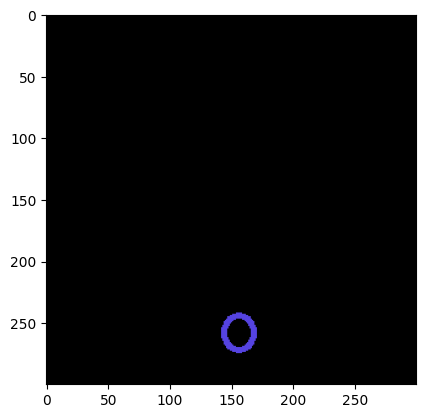

In [6]:
frame_id = 10
tracks,img = dataset.get_frame(frame_id)
plt.imshow(img)



dets:  [[        182         211         200         227     0.80258]
 [         29         249          58         270     0.84515]
 [        191         229         215         239      0.9753]
 [         12          99          36         119     0.94122]
 [        220          59         242          91     0.87893]
 [        220          90         236         114     0.84807]]
tracks:  [[184 210 202 227]
 [ 25 252  54 270]
 [195 228 212 238]
 [ 16  99  41 116]
 [219  60 243  88]
 [220  91 234 111]]


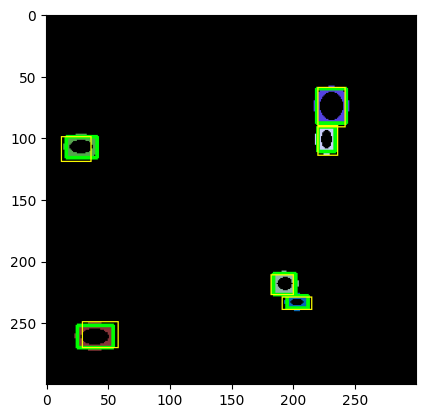

In [15]:
# frame_id = 100
frame_id += 2
tracks, image, dets = dataset.get_frame_and_detections(frame_id)

color = (255,255,0)
thickness = 2
print("dets: ",dets)
print("tracks: ",tracks)
color_tracks = (0,255,0)
for i in range(len(tracks)):

  point1 = tracks[i,:2].astype(np.int32)
  point2 = tracks[i,2:4].astype(np.int32)
  image = cv2.rectangle(image, point1, point2, color=color_tracks, thickness=thickness)

for i in range(len(dets)):

  point1 = dets[i,:2].astype(np.int32)
  point2 = dets[i,2:4].astype(np.int32)
  image = cv2.rectangle(image, point1, point2, color=color, thickness=1)

#### CODE HERE ####

plt.imshow(image)

# Tracking a single object
We are going to see if we can can build a tracker for a single object.
1. Analize multiple frames and determine main challenges.

In [17]:
dataset = TrackingEllipseGenerator(300,n_tracks=1,image_shape=[300,300],duration_samples=[299,300],
                                   false_negative_rate=0,false_positive_rate=0.5)

idx = 0

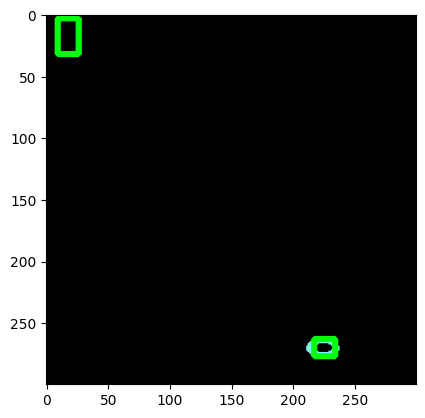

In [18]:
idx += 1
tracks,img,dets = dataset.get_frame_and_detections(idx,draw_detection=True)
plt.imshow(img)

# Kalman tracking
1. Define a function calculate the L2 distance between a vector of size [4] and a matrix of size [n,4]. And produce n distances.
2. Modified the Tracker class to have a find_observation method. This recieves N new detections and return the closest to the currently tracked object. If there are no close detections then return and empty array.
3. Modified to code to have an input "u" diferent than 0. The input "u" represent the acceleration.

4. Modified the code to use the prior as the final track and increase the variance by 50% in the covariance matrix if there are no detections.



In [19]:
class KalmanFilter:
    def __init__(self, A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray, cov_model_diag=1.0,
                 cov_obs_diag=1.0):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.Q = np.eye(len(A)) * np.array([cov_model_diag])
        self.R = np.eye(len(C)) * np.array([cov_obs_diag])

    def prior(self, x, u):
        return self.A @ x + self.B @ u

    def observation(self, x, u):
        return self.C @ x + self.D @ u

    def posterior(self, x, prior_x, u, observation, P):
        z_prior = self.observation(x, u)  # estimation
        prior_P = self.A @ P @ self.A + self.Q
        W = prior_P @ self.C.transpose() @ np.linalg.inv(self.C @ prior_P @ self.C.transpose() + self.R)  # Kalman gain
        post_x = prior_x + W @ (observation - z_prior)  # posterior
        post_P = (np.eye(len(P)) - W @ self.C) @ prior_P  #
        return post_x, post_P

def get_kalman_filter(variance_model= 20,variance_observation=40):
    A = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                  [0, 1, 0, 0, 0, 1, 0, 0],
                  [0, 0, 1, 0, 0, 0, 1, 0],
                  [0, 0, 0, 1, 0, 0, 0, 1],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

    B = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

    C = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

    D = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])

    return KalmanFilter(A, B, C, D,variance_model, variance_observation)


def format_detections(detections: np.ndarray, speed=0):
    """
    Function to format detections into a position format
    :param detections: detection array to be formatted into a matrix of columns [x1,y1,x2,y2,x'1,y'1,x'2,y'2]. Initial
    speed is zero.
    :return:
    """
    detection = np.zeros([len(detections), 8])
    detection[:, :4] = detections[:, :4]
    detection[:, 4:] += speed
    return detection

kalman = get_kalman_filter()

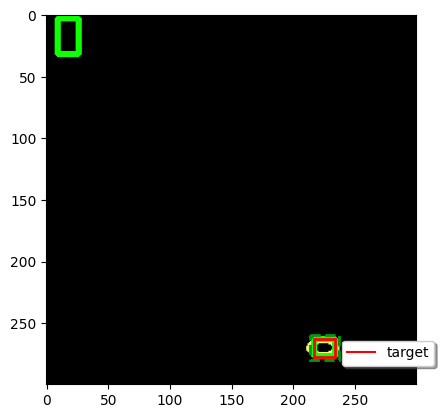

In [42]:
def calculate_iou_distance(target: np.ndarray, matrix2: np.ndarray):
    """
    Calculate IoU correlation between locations in matrices
    :param target: Position matrix array as [x1,y1,x2,y2] columns
    :param matrix2: Position matrix array as [x1,y1,x2,y2] columns
    :return:
    """
    target = np.reshape(target,[-1,4])
    inter = np.maximum(np.minimum(target[:, None, 2], matrix2[:, 2]) - np.maximum(target[:, None, 0], matrix2[:, 0]),
                       0)
    inter *= np.maximum(np.minimum(target[:, None, 3], matrix2[:, 3]) - np.maximum(target[:, None, 1], matrix2[:, 1]),
                        0)
    eps = 0.000001

    # Union Area
    w1, h1 = target[:, 2] - target[:, 0], target[:, 3] - target[:, 1] + eps
    w2, h2 = matrix2[:, 2] - matrix2[:, 0], matrix2[:, 3] - matrix2[:, 1] + eps
    union = ((w1 * h1)[:, None] + w2 * h2) - inter + eps

    iou = inter / union
    return iou

def calculate_distance(target: np.ndarray, matrix2: np.ndarray):
    """
    Calculate the distance between the target vector and some detection matrix
    :param target: Position matrix array as [x1,y1,x2,y2] columns
    :param matrix2: Position matrix array as [x1,y1,x2,y2] columns
    :return:
    """
    n_rows = matrix2.shape[0]
    distance = np.zeros([n_rows])
    for i in range(n_rows):
        distance[i] = np.linalg.norm(target - matrix2[i,:])
    return distance

class Tracker:
    def __init__(self,initial_position,kalman_filter:KalmanFilter,initial_covariance = 10):
        self.target = initial_position
        self.tracks = [initial_position.copy()]
        self.kalman = kalman_filter
        self.covariance_target = np.eye(8) * initial_covariance

    def find_observation(self,new_detections, threshold=80):
        ###### CODE HERE ######
        result_distances = calculate_distance(self.target[:4],new_detections[:,:4])
        index_lower = np.argmin(result_distances)
        # if result_distances[index_lower] < threshold:
        return format_detections(new_detections[index_lower,:4][None])


    def process_frame(self,new_detections):

        observation = self.find_observation(new_detections)

        if len(new_detections) == 0:
            u = np.zeros([4])
        else:
            u = np.zeros([4])
            ###### CODE HERE ######

        prior_location = self.kalman.prior(self.target,u)

        if len(observation) > 0:

            # observation = format_detections(observation[:4])
            observation = observation[0,:]
            posterior_location, updated_covariance =  self.kalman.posterior(x=self.target,
                                                                                    prior_x = prior_location,
                                                                                    u = np.zeros([4]),
                                                                                    observation = observation,
                                                                                    P = self.covariance_target)
            self.covariance_target = updated_covariance
            self.target = posterior_location
            self.tracks.append(posterior_location.copy())




    def plot_tracking_position(self,img,color=(0,0.6,0.05),color_target = (0, 0, 1.0)):

        fig, ax = plt.subplots()
        p1 = self.target[:2]
        wh = self.target[2:4] - self.target[:2]
        ax.add_patch(Rectangle(p1.tolist(), wh[0], wh[1],
                               edgecolor = 'red',
                               # facecolor = 'blue',
                               fill=False,
                               lw=2))

        variance_x = self.covariance_target[0,0]
        variance_y = self.covariance_target[1,1]
        range_variance1 = np.array([np.sqrt(variance_x),np.sqrt(variance_y)])
        variance_x = self.covariance_target[2,2]
        variance_y = self.covariance_target[3,3]
        range_variance2 = np.array([np.sqrt(variance_x),np.sqrt(variance_y)])
        p1 = self.target[:2] - range_variance1
        p2 = self.target[2:4] + range_variance2
        wh = p2 - p1




        #add rectangle to plot

        ax.add_patch(Rectangle(p1.tolist(), wh[0], wh[1],
                               edgecolor = color,
                               fill=False,
                               linestyle ='--',
                               lw=2))

        dash_length = 6
        gap_length = 5

        thickness = 2

        x_start, x_end = 250, 275
        # # Draw dashed line
        y = 275
        # x = x_start

        # while x < x_end:
        #     x2 = min(x + dash_length, x_end)
        #     cv2.line(img, (x, y), (x2, y), color_target, thickness=thickness)
        #     x += dash_length + gap_length

        # # Add legend text
        # cv2.putText(img, "pos", (2 * x_start- x_end - 15 , y + 5), cv2.FONT_HERSHEY_SIMPLEX,
        #             0.7, (0, 0, 255), 2, cv2.LINE_AA)

        # #create simple line plot
        ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.plot(np.linspace(x_start,x_end,2),[y,y],color=np.flip(color_target),label='target')
        ax.legend(loc=[x_start,y], bbox_to_anchor=(0.8, 0.05),
          fancybox=True, shadow=True, ncol=5)


tracker = Tracker(format_detections(dets)[0],kalman)
id_frame = 0

tracker.plot_tracking_position(img.copy())

In [43]:
###### EXAMPLE CALCULATE DISTANCE ###########
################## x1, y1, x2, y2 ##################
target = np.array([255,159,275,189])
print("target: ",target)
n_dets = 7
matrix_data = target[None] + np.random.randint(-160,160,[n_dets,4])
print("matrix_data: \n",matrix_data)
matrix_data[-1,:3] = target[:3]
result_distances = calculate_distance(target,matrix_data)
print("result_distances: ",result_distances)


target:  [255 159 275 189]
matrix_data: 
 [[302 146 332  83]
 [223 207 158 232]
 [243 296 184 207]
 [105  15 370 312]
 [145  87 282 174]
 [402 287 402  36]
 [391 309 133 293]]
result_distances:  [     129.86      137.35      165.89       259.6      132.51      278.44         104]


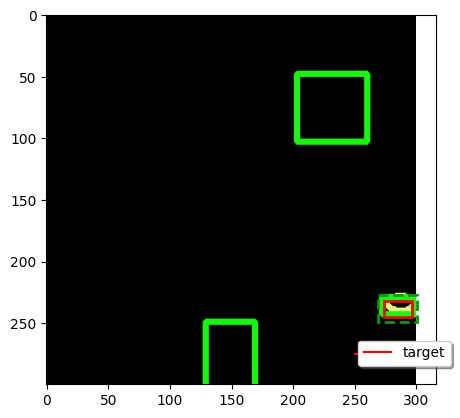

In [66]:
id_frame += 1
tracks,img,dets = dataset.get_frame_and_detections(id_frame,draw_detection=True)
# plt.imshow(img)
# plt.show()
tracker.process_frame(dets)
tracker.plot_tracking_position(img)


In [ ]:
tracker.target

# Tracking cherries

In [67]:

bytetrack_params = """
tracker_type: bytetrack # (str) Tracker backend: botsort|bytetrack; choose bytetrack for the classic baseline
track_high_thresh: 0.25 # (float) First-stage match threshold; raise for cleaner tracks, lower to keep more
track_low_thresh: 0.1 # (float) Second-stage threshold for low-score matches; balances recovery vs drift
new_track_thresh: 0.25 # (float) Start a new track if no match ≥ this; higher reduces false tracks
track_buffer: 30 # (int) Frames to keep lost tracks alive; higher handles occlusion, increases ID switches risk
match_thresh: 0.8 # (float) Association similarity threshold (IoU/cost); tune with detector quality
fuse_score: True # (bool) Fuse detection score with motion/IoU for matching; stabilizes weak detections
"""

botsort_params = """
tracker_type: botsort # (str) Tracker backend: botsort|bytetrack; choose botsort to enable BoT-SORT features
track_high_thresh: 0.25 # (float) First-stage match threshold; raise for cleaner tracks, lower to keep more
track_low_thresh: 0.1 # (float) Second-stage threshold for low-score matches; balances recovery vs drift
new_track_thresh: 0.25 # (float) Start a new track if no match ≥ this; higher reduces false tracks
track_buffer: 30 # (int) Frames to keep lost tracks alive; higher handles occlusion, increases ID switches risk
match_thresh: 0.8 # (float) Association similarity threshold (IoU/cost); tune with detector quality
fuse_score: True # (bool) Fuse detection score with motion/IoU for matching; stabilizes weak detections

# BoT-SORT specifics
gmc_method: sparseOptFlow # (str) Global motion compensation: sparseOptFlow|orb|none; helps moving camera scenes

# ReID model related thresh
proximity_thresh: 0.5 # (float) Min IoU to consider tracks proximate for ReID; higher is stricter
appearance_thresh: 0.8 # (float) Min appearance similarity for ReID; raise to avoid identity swaps
with_reid: False # (bool) Enable ReID model use; needs extra model and compute
model: auto # (str) ReID model name/path; "auto" uses detector features if available
"""

bytetrack_dict = yaml.safe_load(bytetrack_params)
botsort_dict = yaml.safe_load(botsort_params)
with open('bytetrack.yaml', 'w') as file:
    yaml.dump(bytetrack_dict, file)

with open('botsort.yaml', 'w') as file:
    yaml.dump(botsort_dict, file)

# Video Tracking
1. Generate a video with tracked cherries and analyze the results.

In [69]:
model = YOLO('yolov11_best.pt')
path_video = './short_video1.mov'
# results = model.track(path_video, conf=0.3, iou=0.5, save=True, show=True, tracker="bytetrack.yaml")

In [ ]:
results

# Count and classify
1. Count how many cherries are across the video

In [70]:
cap = cv2.VideoCapture(path_video)
success = True
# Loop through the video frames


In [72]:
for i in range(5):
# Read a frame from the video
  success, frame = cap.read()

  if success:
    shape = frame.shape
    results = model.track([frame[:shape[1],:shape[1]]], persist=True)


requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 4.7s, installed 1 package: ['lap>=0.5.12']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


0: 1088x1088 4 unripes, 8 ripes, 6890.8ms
Speed: 28.4ms preprocess, 6890.8ms inference, 34.5ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 4 unripes, 8 ripes, 5149.0ms
Speed: 16.4ms preprocess, 5149.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 4 unripes, 7 ripes, 6690.9ms
Speed: 15.8ms preprocess, 6690.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 4 unripes, 7 ripes, 7296.7ms
Speed: 14.1ms preprocess, 7296.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 4 unripes, 7 ripes, 6704.8ms
Speed: 13.6ms preprocess, 6704.8ms inference, 1.4ms 

In [74]:
results[-1].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 2., 2., 1., 1., 1., 2., 2., 1., 2.])
conf: tensor([0.9040, 0.8631, 0.8990, 0.7344, 0.7485, 0.1024, 0.5325, 0.3661, 0.3224, 0.5364, 0.3139])
data: tensor([[9.7186e+02, 5.1125e+02, 1.0271e+03, 5.7297e+02, 1.0000e+00, 9.0400e-01, 2.0000e+00],
        [9.3772e+02, 5.2910e+02, 9.8204e+02, 5.8927e+02, 2.0000e+00, 8.6313e-01, 2.0000e+00],
        [7.9787e+02, 4.3274e+02, 8.4860e+02, 4.8640e+02, 3.0000e+00, 8.9899e-01, 2.0000e+00],
        [9.3156e+02, 4.9752e+02, 9.5482e+02, 5.4951e+02, 4.0000e+00, 7.3437e-01, 2.0000e+00],
        [9.5924e+02, 4.8159e+02, 9.9587e+02, 5.2505e+02, 5.0000e+00, 7.4846e-01, 1.0000e+00],
        [6.5489e+01, 1.0429e+03, 9.3219e+01, 1.0638e+03, 6.0000e+00, 1.0239e-01, 1.0000e+00],
        [8.9732e+02, 4.6894e+02, 9.2872e+02, 4.8558e+02, 7.0000e+00, 5.3254e-01, 1.0000e+00],
        [3.8438e+02, 7.7469e+02, 4.0032e+02, 7.9406e+02, 8.0000e+00, 3.6611e-01, 2.0000e+00],
        [4.1657e+02, 7.

In [ ]:
bb = results[-1].boxes.xywh
img = results[-1].orig_img
